In [ ]:
%pip install pycocoevalcap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/gdrive')

from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os

# # folder path
# dir_path = r'/content/gdrive/Shareddrives/DLSD/Images'
# count = 0
# # Iterate directory
# for path in os.listdir(dir_path):
#     # check if current path is a file
#     if os.path.isfile(os.path.join(dir_path, path)):
#         count += 1
# print('File count:', count)

In [ ]:
#Class for metrics calclulation
class COCOEvalCap:
    def __init__(self,images,gts,res):
        self.evalImgs = []
        self.eval = {}
        self.imgToEval = {}
        self.params = {'image_id': images}
        self.gts = gts
        self.res = res

    def evaluate(self):
        imgIds = self.params['image_id']
        gts = self.gts
        res = self.res
        print('tokenization...')
        tokenizer = PTBTokenizer()
        gts  = tokenizer.tokenize(gts)
        res = tokenizer.tokenize(res)
        print('setting up scorers...')
        scorers = [
            (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
            (Meteor(),"METEOR"),
            (Rouge(), "ROUGE_L"),
            (Cider(), "CIDEr"),
            (Spice(), "SPICE")
        ]

        # =================================================
        # Compute scores
        # =================================================
        eval = {}
        for scorer, method in scorers:
            print('computing %s score...'%(scorer.method()))
            score, scores = scorer.compute_score(gts, res)
            if type(method) == list:
                for sc, scs, m in zip(score, scores, method):
                    self.setEval(sc, m)
                    self.setImgToEvalImgs(scs, imgIds, m)
                    print("%s: %0.3f"%(m, sc))
            else:
                self.setEval(score, method)
                self.setImgToEvalImgs(scores, imgIds, method)
                print("%s: %0.3f"%(method, score))
        self.setEvalImgs()

    def setEval(self, score, method):
        self.eval[method] = score

    def setImgToEvalImgs(self, scores, imgIds, method):
        for imgId, score in zip(imgIds, scores):
            if not imgId in self.imgToEval:
                self.imgToEval[imgId] = {}
                self.imgToEval[imgId]["image_id"] = imgId
            self.imgToEval[imgId][method] = score

    def setEvalImgs(self):
        self.evalImgs = [eval for imgId, eval in self.imgToEval.items()]

In [ ]:
BASE_DIR = r'/content/gdrive/Shareddrives/DLSD/'
WORKING_DIR =  r'/content/gdrive/Shareddrives/DLSD/'

In [ ]:
directory_images = os.path.join(BASE_DIR, 'Images')

metadata = pd.read_csv(os.path.join(BASE_DIR, 'captions.txt'),delimiter=',',engine='python')
metadata = metadata.dropna()
is_NaN = metadata.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = metadata[row_has_NaN]
print(rows_with_NaN)
metadata.head()
# print(len(metadata))

Empty DataFrame
Columns: [image, caption]
Index: []


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
len(metadata['image'].unique())

8091

In [ ]:
def load_image(name):
    img = image.load_img(name,target_size=(32,32,3))
    img = image.img_to_array(img)
    #img = img/255
    #plt.imshow(img)
    img = np.reshape(img,(32*32*3))
    return img

In [ ]:
image_arr = []
sentence_arr = []
for ind in tqdm(range(5000)):
    if ind % 5 != 0:
        continue
    image_location = (metadata.iloc[ind,:]['image'])
    sentence = (metadata.iloc[ind,:]['caption'])
    
    
    image_arr.append(load_image(os.path.join(BASE_DIR,'Images')+'/'+str(image_location)) )
    sentence_arr.append('<SOS>'+sentence+'<EOS>')
    
        
Images =  np.array(image_arr)
print(Images.shape)

100%|██████████| 5000/5000 [02:05<00:00, 39.71it/s] 

(1000, 3072)


In [ ]:
def tokenize(x):
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(x)
    t=tokenizer.texts_to_sequences(x)
    return t, tokenizer

text_sentences = [
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


In [ ]:
def pad(x, length=None):
    padding=pad_sequences(x,padding='post',maxlen=length)
    return padding
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


In [ ]:
def preprocess(sentences):
    text_tokenized, text_tokenizer = tokenize(sentences)
    text_pad = pad(text_tokenized)
    return text_pad, text_tokenizer

Sentence , token_Sentence = preprocess(sentence_arr)

In [ ]:
print("Sentence vocabulary size:", len(token_Sentence.word_index))
print("Sentence Longest sentence size:", len(Sentence[0]))

Sentence vocabulary size: 1503
Sentence Longest sentence size: 35


In [ ]:
Images.shape , Sentence.shape

((1000, 3072), (1000, 35))

In [ ]:
Sentence

array([[  2,   1,  30, ...,   0,   0,   0],
       [  2,   1,  14, ...,   0,   0,   0],
       [  2,   1,  37, ...,   0,   0,   0],
       ...,
       [  2,   1,  15, ...,   0,   0,   0],
       [  2,   1, 117, ...,   0,   0,   0],
       [  2,   1,  17, ...,   0,   0,   0]], dtype=int32)

In [ ]:
def create_batch(src, tar , batchsize , i):
    src, tar =  np.transpose(src[(i-1)*batchsize : (i-1)*batchsize + batchsize]) , np.transpose(tar[(i-1)*batchsize : (i-1)*batchsize + batchsize])
    return torch.tensor(src).long(),torch.tensor(tar).long()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
class Transformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        forward_expansion,
        dropout,
        max_len_s,
        max_len_t,
        device,
    ):
        super(Transformer, self).__init__()
        self.src_word_embedding = nn.Embedding(src_vocab_size, embedding_size)
        self.src_position_embedding = nn.Embedding(max_len_s, embedding_size)
        self.trg_word_embedding = nn.Embedding(trg_vocab_size, embedding_size)
        self.trg_position_embedding = nn.Embedding(max_len_t, embedding_size)

        self.device = device
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
        )
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = src_pad_idx

    def make_src_mask(self, src):
        src_mask = src.transpose(0, 1) == self.src_pad_idx

        # (N, src_len)
        return src_mask.to(self.device)

    def forward(self, src, trg):
        src_seq_length, N = src.shape
        trg_seq_length, N = trg.shape

        src_positions = (
            torch.arange(0, src_seq_length)
            .unsqueeze(1)
            .expand(src_seq_length, N)
            .to(self.device)
        )

        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(1)
            .expand(trg_seq_length, N)
            .to(self.device)
        )

        embed_src = self.dropout(
            (self.src_word_embedding(src) + self.src_position_embedding(src_positions))
        )
        embed_trg = self.dropout(
            (self.trg_word_embedding(trg) + self.trg_position_embedding(trg_positions))
        )

        src_padding_mask = self.make_src_mask(src)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(self.device)
        out = self.transformer(
            embed_src,
            embed_trg,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=trg_mask,
        )
        out = self.fc_out(out)
        return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Model hyperparameters
src_vocab_size = 256
trg_vocab_size = len(token_Sentence.word_index)
embedding_size = 512
num_heads = 8
num_encoder_layers = 3
num_decoder_layers = 3
dropout = 0.10
max_len_s = Images.shape[1]
max_len_t = len(Sentence[0])
forward_expansion = 4
src_pad_idx = 0


In [ ]:
# Training hyperparameters
num_epochs = 10000
learning_rate = 3e-4
batch_size = 1

In [ ]:
model = Transformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len_s,
    max_len_t,
    device,
).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=10, verbose=True
)

pad_idx = 0
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).cuda()

In [ ]:
import time
def train():
    model.train()
    total_loss = 0
    start_time = time.time()
    for i in range(1, 999):
        src,tar = create_batch(Images,Sentence, batch_size , i)
        src = src.to(device)
        tar = tar.to(device)
        optimizer.zero_grad()
        output = model(src,tar)
        loss = criterion(output.view(-1, output.shape[2]), tar.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        cur_loss = loss.item()
        total_loss += cur_loss
        log_interval = 100
        if i % log_interval == 0 and i > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  's/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, i, (src.shape[1]) // batch_size, 
                    elapsed  / log_interval,
                    cur_loss, math.exp(cur_loss)))
            start_time = time.time()
    return total_loss

In [ ]:
import math
for epoch in range(1, 3):
    epoch_start_time = time.time()
    loss = train()
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | Training loss {:5.2f} | '
          .format(epoch, (time.time() - epoch_start_time),
                                     loss))

| epoch   1 |   100/    1 batches | s/batch 14.37 | loss  3.25 | ppl    25.79
| epoch   1 |   200/    1 batches | s/batch 14.70 | loss  1.44 | ppl     4.21


In [ ]:
import pickle

pickle.dump(model, open(os.path.join(BASE_DIR, 'e2eTransformer.pkl'), 'wb'))


In [ ]:
def display_image(name):
    img = image.load_img(name,target_size=(512,512,3))
    img = image.img_to_array(img)
    img = img/255
    plt.imshow(img)

In [ ]:
def evaluate(index):
    image_location, sent = metadata.iloc[index,0],metadata.iloc[index,1]
    # print(sent)
    image_arr = []
    img = load_image(os.path.join(BASE_DIR,'Images')+'/'+str(image_location))
    image_arr.append(img)
    img_arr = np.array(image_arr)
    sentence = []
    sentence.append(sent)
    sentence[0] = '<SOS> '+sentence[0]+'<EOS>'
    sentence = pad(token_Sentence.texts_to_sequences(sentence) , length = max_len_t)
    src , tar = create_batch(img_arr,sentence, 1,1)
    src = src.to(device)
    tar = tar.to(device)
    model.eval()
    output =  model(src,tar)
    loss = criterion(output.view(-1, output.shape[2]), tar.reshape(-1))
    sentence_formed = ''
    val, ind = torch.max(output.view(-1, output.shape[2]), 1)
    for word in ind:
        if word.item() == 3: # EOS
                break
        for key, value in token_Sentence.word_index.items():
            if value == word.item() and value != 2: # sos
                sentence_formed = sentence_formed + key +' '
                break
    display_image(os.path.join(BASE_DIR,'Images')+'/'+str(image_location))
    return sentence_formed , loss

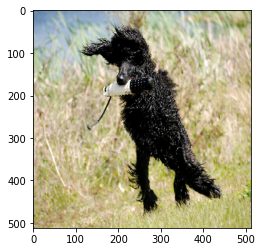

In [ ]:
imgIds = []
gts = {}
res = {}


for ind in range(5000, 8000):
    if ind%5 != 0:
      continue
    imgIds.append(metadata.iloc[ind,0])
    captions = metadata.iloc[ind,1]
    y_pred, y_loss = evaluate(ind)
    gts[metadata.iloc[ind,0]] = [{'image_id': metadata.iloc[ind,0], 'caption': captions}]
    res[metadata.iloc[ind,0]] = [{'image_id': metadata.iloc[ind,0], 'caption': y_pred}]
    


In [ ]:
print(gts['2098646162_e3b3bbf14c.jpg'])
print(res['2098646162_e3b3bbf14c.jpg'])

evalObj = COCOEvalCap(imgIds,gts,res)
evalObj.evaluate()

print(evalObj.eval)


[{'image_id': '2098646162_e3b3bbf14c.jpg', 'caption': 'A black and gray cat stands on a contracption while two big dogs stare at it .'}]
[{'image_id': '2098646162_e3b3bbf14c.jpg', 'caption': 'a black and gray grassy stands on a while two big dogs at it '}]
tokenization...
setting up scorers...
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
computing Bleu score...
{'testlen': 6184, 'reflen': 6681, 'guess': [6184, 5584, 4985, 4390], 'correct': [6023, 4968, 4061, 3269]}
ratio: 0.9256099386318027
Bleu_1: 0.899
Bleu_2: 0.859
Bleu_3: 0.822
Bleu_4: 0.786
computing METEOR score...
METEOR: 0.523
computing Rouge score...
ROUGE_L: 0.925
computing CIDEr score...
CIDEr: 7.374
computing SPICE score...
SPICE: 0.767
{'Bleu_1': 0.8987516530909919, 'Bleu_2': 0.8589860281084055, 'Bleu_3': 0.8216347182996252, 'Bleu_4': 0.7857253528823565, 'METEOR': 0.5231072864118824, 'ROUGE_L': 0.9248223358152152, 'CIDEr': 7.373605479550479, 'SPICE': 0.7670200202782514}


A brown and white dog is jumping up , with a stick in its mouth .
a brown and white dog is jumping up with a stick in its mouth 


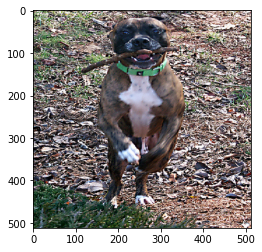

In [ ]:
x, _ = evaluate(6000)
print(metadata.iloc[6000,1])
print(x)

('a little girl covered in winter sits in front of a painted rainbow with her hands in a bowl ',
 tensor(0.4510, device='cuda:0', grad_fn=<NllLossBackward0>))

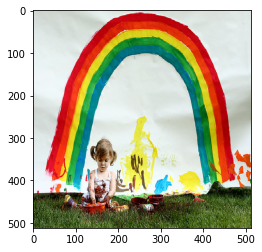

In [ ]:
evaluate(10)

('a brown and white dog is running through the snow ',
 tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>))

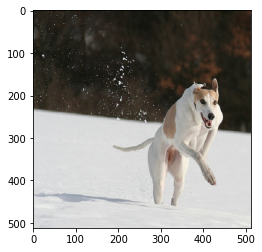

In [ ]:
evaluate(50)

('a little boy is standing on the street while a man in is on a stone wall ',
 tensor(0.0599, device='cuda:0', grad_fn=<NllLossBackward0>))

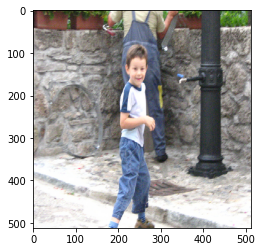

In [ ]:
evaluate(41)

In [ ]:
# import torch
# torch.cuda.empty_cache()

# import gc
# # del variables
# gc.collect()

# torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    5541 MB |    5751 MB |   16022 GB |   16016 GB |\n|       from large pool |    5486 MB |    5698 MB |   15922 GB |   15917 GB |\n|       from small pool |      55 MB |      55 MB |      99 GB |      99 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |    5541 MB |    5751 MB |   16022 GB |   16016 GB |\n|       from large pool |    5486 MB |    5698 MB |

('a group of group children sit at a wooden table ',
 tensor(0.4951, device='cuda:0', grad_fn=<NllLossBackward0>))

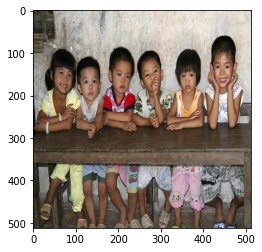

In [ ]:
evaluate(40400)

In [ ]:
print(metadata.iloc[10,0])

1002674143_1b742ab4b8.jpg
